In [2]:
import numpy as np
import cv2
from PIL import Image
from tensorflow.keras.models import load_model
import os
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from collections import Counter
import joblib
import matplotlib.pyplot as plt
from io import BytesIO
import IPython.display as display
import ipywidgets as widgets

In [3]:
gender_model_path_resnet = 'gender_model_resnet.h5'
gender_model_path_inception = 'gender_model_inception.h5'
gender_model_path_cnn = 'gender_model_cnn.h5'

In [4]:
gender_model_resnet = load_model(gender_model_path_resnet)
gender_model_inception = load_model(gender_model_path_inception)
gender_model_cnn = load_model(gender_model_path_cnn)

In [5]:
def process_and_predict_resnet50(pil_img):
    pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)
    pil_img_rgb = pil_img_resized.convert('RGB')
    img_array = np.array(pil_img_rgb)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded.astype('float32') / 255.0
    gender_prob = gender_model_resnet.predict(img_array_normalized)
    gender = "male" if gender_prob[0][0] < 0.5 else "female"
    return gender

In [6]:
def process_and_predict_inceptionv3(pil_img):
    pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)
    pil_img_rgb = pil_img_resized.convert('RGB')
    img_array = np.array(pil_img_rgb)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_array_normalized = img_array_expanded.astype('float32') / 255.0
    gender_prob = gender_model_inception.predict(img_array_normalized)
    gender = "female" if gender_prob[0][0] < 0.5 else "male"
    return gender

In [7]:
def process_and_predict_cnn(img_gray_face):
    img_gray_face_resized = cv2.resize(img_gray_face, (100, 100))
    img_gray_face_reshaped = img_gray_face_resized.reshape(-1, 100, 100, 1)
    gender_prob = gender_model_cnn.predict(img_gray_face_reshaped)
    gender = "male" if gender_prob[0][0] < 0.5 else "female"
    return gender


In [8]:
path = "crop_part1"
pixels = []
gender = []

for img in os.listdir(path):
    genders = img.split("_")[1]
    img = cv2.imread(str(path)+"/"+str(img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (100, 100))
    pixels.append(np.array(img))
    gender.append(np.array(genders))

pixels = np.array(pixels)
gender = np.array(gender, np.uint64)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(pixels, gender, random_state=100)

In [10]:
resnet50_predictions = []
inceptionv3_predictions = []
cnn_predictions = []
true_labels = []

In [11]:
for img_gray, label in zip(x_test, y_test):
    pil_img = Image.fromarray(img_gray)

In [12]:
all_predictions = [resnet50_predictions, inceptionv3_predictions, cnn_predictions]
ensemble_predictions = []

In [13]:
for sample_predictions in zip(*all_predictions):
    majority_vote = Counter(sample_predictions).most_common(1)[0][0]
    ensemble_predictions.append(majority_vote)

In [14]:
label_encoder = LabelEncoder()

In [15]:
y_val_encoded = label_encoder.fit_transform(true_labels)

In [16]:
ensemble_predictions_encoded = label_encoder.transform(ensemble_predictions)

In [17]:
def predict_gender_ensemble(pil_img):
    gender_resnet50 = process_and_predict_resnet50(pil_img)
    gender_inceptionv3 = process_and_predict_inceptionv3(pil_img)
    gender_cnn = process_and_predict_cnn(np.array(pil_img))

    all_predictions = [gender_resnet50, gender_inceptionv3, gender_cnn]

    vote_counts = {gender: all_predictions.count(gender) for gender in gender_labels}

    max_count = max(vote_counts.values())
    if list(vote_counts.values()).count(max_count) > 1:
        probabilities = {
            'male': sum(gender_model_resnet.predict_proba(pil_img)[0]),
            'female': sum(1 - gender_model_resnet.predict_proba(pil_img)[0])
        }
        majority_vote = max(probabilities, key=probabilities.get)
    else:
        majority_vote = max(vote_counts, key=vote_counts.get)

    return majority_vote

In [18]:
def predict_gender_ensemble(pil_img):
    gender_resnet50 = process_and_predict_resnet50(pil_img)
    gender_inceptionv3 = process_and_predict_inceptionv3(pil_img)
    gender_cnn = process_and_predict_cnn(img_gray)
    all_predictions = [gender_resnet50, gender_inceptionv3, gender_cnn]
    return gender_resnet50, gender_inceptionv3, gender_cnn, max(set(all_predictions), key=all_predictions.count)



FileUpload(value=(), accept='image/*', description='Upload')

Button(description='Predict Image', style=ButtonStyle())

C:\Users\HP\AppData\Local\Temp\ipykernel_18968\482323211.py:2: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)


1/1 [==============================] - 0s 81ms/step


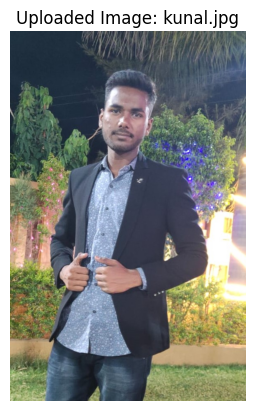

Gender Predictions by Individual Models:
ResNet50 Model Prediction: male
InceptionV3 Model Prediction: male
CNN Model Prediction: female

Gender Prediction by Ensemble Model:
Ensemble Model Prediction: male


In [ ]:
def predict_gender_from_file(image_file):
    filename = image_file.name
    img = cv2.imdecode(np.frombuffer(image_file.content, np.uint8), -1)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    gender_resnet50, gender_inceptionv3, gender_cnn, gender_ensemble = predict_gender_ensemble(pil_img)
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Uploaded Image: ' + filename)
    plt.axis('off')
    plt.show()
    print("Gender Predictions by Individual Models:")
    print("ResNet50 Model Prediction:", gender_resnet50)
    print("InceptionV3 Model Prediction:", gender_inceptionv3)
    print("CNN Model Prediction:", gender_cnn)
    print("\nGender Prediction by Ensemble Model:")
    print("Ensemble Model Prediction:", gender_ensemble)

def on_upload_button_clicked(change):
    # Check the type of file_upload.value
    if isinstance(file_upload.value, dict):
        # If it's a dictionary, handle the case for multiple uploaded files
        for uploaded_filename, uploaded_file in file_upload.value.items():
            predict_gender_from_file(uploaded_file)
    else:
        # If it's not a dictionary, assume a single uploaded file
        predict_gender_from_file(next(iter(file_upload.value)))

file_upload = widgets.FileUpload(accept='image/*')
upload_button = widgets.Button(description='Predict Image')
upload_button.on_click(on_upload_button_clicked)
display.display(file_upload)
display.display(upload_button)


Button(description='Capture Image', style=ButtonStyle())

1/1 [==============================] - 0s 112ms/step


C:\Users\HP\AppData\Local\Temp\ipykernel_18968\482323211.py:2: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  pil_img_resized = pil_img.resize((200, 200), Image.LANCZOS)


1/1 [==============================] - 0s 54ms/step


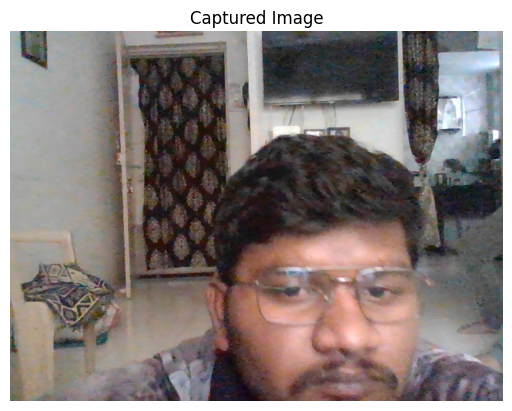

Gender Predictions by Individual Models:
ResNet50 Model Prediction: male
InceptionV3 Model Prediction: female
CNN Model Prediction: female

Gender Prediction by Ensemble Model:
Ensemble Model Prediction: female


In [ ]:
from IPython.display import display, clear_output

def predict_gender_from_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    gender_resnet50, gender_inceptionv3, gender_cnn, gender_ensemble = predict_gender_ensemble(pil_img)
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Captured Image')
    plt.axis('off')
    plt.show()
    print("Gender Predictions by Individual Models:")
    print("ResNet50 Model Prediction:", gender_resnet50)
    print("InceptionV3 Model Prediction:", gender_inceptionv3)
    print("CNN Model Prediction:", gender_cnn)
    print("\nGender Prediction by Ensemble Model:")
    print("Ensemble Model Prediction:", gender_ensemble)

def on_capture_button_clicked(change):
    # Function to handle the button click event
    def capture_and_predict():
        # Capture image from webcam
        cap = cv2.VideoCapture(0)
        ret, frame = cap.read()
        cap.release()
        if ret:
            predict_gender_from_image(frame)
        else:
            print("Failed to capture image from webcam.")

    # Callback function for capturing image when 'c' is pressed
    def on_key_press(event):
        if event == ord('c'):
            capture_and_predict()

    # Create a new window for capturing image from webcam
    cv2.namedWindow("Capture Image", cv2.WINDOW_NORMAL)
    cv2.resizeWindow("Capture Image", 640, 480)
    cv2.moveWindow("Capture Image", 100, 100)

    # Set flag to False initially
    capturing = False

    # Main loop to display webcam feed
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if ret:
            cv2.imshow("Capture Image", frame)
        key = cv2.waitKey(1) & 0xFF
        if key == ord('c'):
            capturing = True
        if capturing:
            capture_and_predict()
            capturing = False
        if key == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create and display the button
capture_button = widgets.Button(description='Capture Image')
capture_button.on_click(on_capture_button_clicked)
display(capture_button)